In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import time
import glob
import tables as tb
import pandas as pd
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi

Running on  Tue May  9 15:48:45 2017


#### General plotting

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/Na_Coincidence"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Usefull functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)



def get_centers(xbins):
    # xbins should be shifted, as it contains the lower bounds
    # and we want bin centers
    return xbins[:-1] + np.diff(xbins) * 0.5


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

two_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1]
one_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) +args[-1]
save = functools.partial(save_to_folder, outputfolder)

### Input data

In [34]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = "/home/brais/Documents/Next/Na/data/"

pattern = "$IC_DATA/3*/dst_*.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))
ifiles = sorted(ifiles)


In [35]:
run_number = [file[44:48] for file in ifiles]

In [36]:
ifiles

['/home/brais/Documents/Next/Na/data/3614/dst_3614.root.h5',
 '/home/brais/Documents/Next/Na/data/3708/dst_3708.root.h5',
 '/home/brais/Documents/Next/Na/data/3723/dst_3723.root.h5',
 '/home/brais/Documents/Next/Na/data/3732/dst_3732.root.h5',
 '/home/brais/Documents/Next/Na/data/3740/dst_3740.root.h5',
 '/home/brais/Documents/Next/Na/data/3752/dst_3752.root.h5',
 '/home/brais/Documents/Next/Na/data/3755/dst_3755.root.h5',
 '/home/brais/Documents/Next/Na/data/3757/dst_3757.root.h5',
 '/home/brais/Documents/Next/Na/data/3761/dst_3761.root.h5',
 '/home/brais/Documents/Next/Na/data/3763/dst_3763.root.h5',
 '/home/brais/Documents/Next/Na/data/3768/dst_3768.root.h5',
 '/home/brais/Documents/Next/Na/data/3770/dst_3770.root.h5',
 '/home/brais/Documents/Next/Na/data/3773/dst_3773.root.h5',
 '/home/brais/Documents/Next/Na/data/3779/dst_3779.root.h5',
 '/home/brais/Documents/Next/Na/data/3781/dst_3781.root.h5',
 '/home/brais/Documents/Next/Na/data/3783/dst_3783.root.h5',
 '/home/brais/Documents/

### Reading data

In [37]:
def load_dst(filename, group, node):
    with tb.open_file(filename) as h5in:
        table = getattr(getattr(h5in.root, group), node).read()
        return pd.DataFrame.from_records(table)
    

In [38]:
data_read = [load_dst(file, "DST", "Events") for file in ifiles]
data_len  = [len(file) for file in data_read]

In [39]:
for i in range(len(data_read)): print(run_number[i], data_len[i])

3614 363085
3708 18
3723 1076
3732 3464
3740 13899
3752 16682
3755 14870
3757 17051
3761 16570
3763 6492
3768 9593
3770 6688
3773 9117
3779 3934
3781 3131
3783 7855
3787 6884
3789 9584
3791 8695
3794 9106
3890 11319
3896 5387
3898 11185
3901 19530
3904 50165


### Some plots

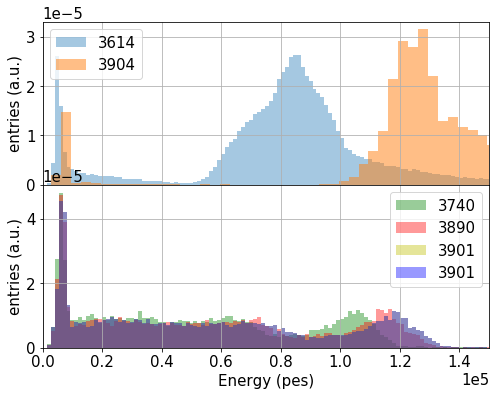

In [98]:

f = plt.figure()
plt.subplots_adjust(hspace=0.001)


ax1 = plt.subplot(211)


data_ = data_read[0]
data_ = data_[(data_.S1e>100)& (data_.S1e<150)]
plt.subplot(2,1,1)
plt.hist(data_.S2e , 150, [0.75, 2e5], alpha=0.4, label=run_number[0] , normed=True)
data_ = data_read[-1]
data_ = data_[(data_.S1e>100)& (data_.S1e<150)]
plt.hist(data_.S2e, 150, alpha=0.5, label=run_number[-1], normed=True)
plt.legend()
plt.xlim(0.75,1.5e5)
plt.grid()
a = ax1.get_xticklabels()
plt.setp(a, visible=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylabel('entries (a.u.)')

ax2 = plt.subplot(2,1,2)
plt.hist(data_read[4].S2e , 150, [0.75, 2e5], alpha=0.4, label=run_number[4] , normed=True, color='g')
plt.hist(data_read[-5].S2e, 150, [0.75, 2e5], alpha=0.4, label=run_number[-5], normed=True, color='r')
plt.hist(data_read[-2].S2e, 150, [0.75, 2e5], alpha=0.4, label=run_number[-2], normed=True, color='y')
plt.hist(data_read[-2].S2e, 150, [0.75, 2e5], alpha=0.4, label=run_number[-2], normed=True, color='b')
plt.grid()
plt.legend()
plt.xlim(0.75,1.5e5)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Energy (pes)')
plt.ylabel('entries (a.u.)')
plt.show()

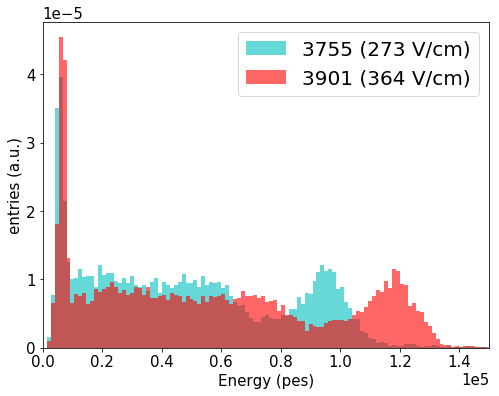

In [119]:
data_ = data_read[0]
#data_ = data_[(data_.S1e>100)& (data_.S1e<150)]

#plt.hist(data_.S2e , 150, [0.75, 2e5], alpha=0.4, label=run_number[0] , normed=True)
data_ = data_read[-1]
data_ = data_[(data_.S1e>100)& (data_.S1e<150)]
#plt.hist(data_.S2e, 150, alpha=0.5, label=run_number[-1], normed=True)
plt.hist(data_read[6].S2e , 150, [0.75, 2e5], alpha=0.6, label=run_number[6]+' (273 V/cm)' , normed=True, color='c')
#plt.hist(data_read[-5].S2e, 150, [0.75, 2e5], alpha=0.4, label=run_number[-5], normed=True, color='r')
#plt.hist(data_read[-2].S2e, 150, [0.75, 2e5], alpha=0.4, label=run_number[-2], normed=True, color='y')
plt.hist(data_read[-2].S2e, 150, [0.75, 2e5], alpha=0.6, label=run_number[-2]+' (364 V/cm)', normed=True, color='r')
#plt.grid()
plt.legend(fontsize=20)
plt.xlim(0.75,1.5e5)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Energy (pes)')
plt.ylabel('entries (a.u.)')
plt.show()

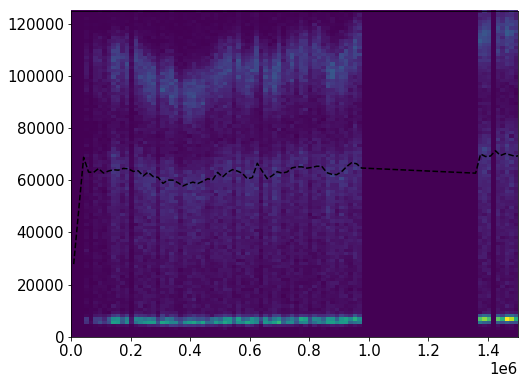

In [13]:
data = data_read_combined[(data_read_combined.Z<210)&(data_read_combined.R<180)]

Et = data.S2e 

time = data.time
time = time-np.min(time)
hist2d(time,Et,[100,100], range=[[0,1.5e6],[0,1.25e5]]);
x, y, _ = fitf.profileX(time,Et, 100, yrange=[0,2e5])
plt.plot(x,y,profOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

3.0412741907860936

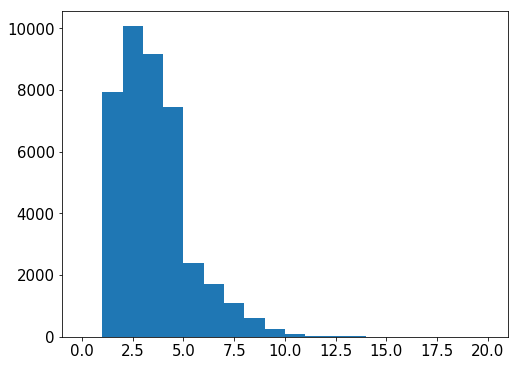

In [14]:
hist(data_read_combined[(data_read_combined.nS2>0)&(data_read_combined.S2e<12e3)].Nsipm, 20, [0,20]);
np.mean(data_read_combined[(data_read_combined.nS2>0)&(data_read_combined.S2e<12e3)].Nsipm)


### XR Filter

In [ ]:
from copy import deepcopy
from functools import reduce

def Filter(data, verbosity=False):
    filtered_XR = deepcopy(data)
    filtered_noXR = deepcopy(data)
    
    min_S1w = 250.
    max_S1w = 400.
    min_S1h = 10.
    max_S1h = 100.
    
    min_S2e = 2500.
    max_S2e = 10000.
    
    if verbosity: print('Inicial: ',len(filtered_XR), len(filtered_noXR))

    filtered_XR = filtered_XR[filtered_XR.nS2>1]
    if verbosity: print('nS2 > 1: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.S2e>min_S2e]
    filtered_XR = filtered_XR[filtered_XR.S2e<max_S2e]
    
    
    if verbosity: print('S2 XR Energy: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.Nsipm>0]
    
    if verbosity: print('Nsimp > 0: ', len(filtered_XR))
    

    
    
    #filtered_noXR = filtered_noXR[filtered_noXR.S2e<min_S2e]
    filtered_noXR = filtered_noXR[filtered_noXR.S2e>max_S2e]
    
    if verbosity: print('no XR: ', len(filtered_noXR))
    
    return filtered_XR, filtered_noXR


In [ ]:
filt_XR, filt_noXR = [], []
for i in data_read:
    
    XR, noXR = Filter(i,True)
    filt_XR.append(XR)
    filt_noXR.append(noXR)

#full = data_read[:]

In [ ]:
min_len   = 1000
len_XR    = [len(Filter(data)[0]) for data in data_read]
print(len_XR)

In [ ]:
rcut = 180.
data_cut = []
i = 0
def get_zcorr(zfun, coef):
    def zcorr(z):
        return zfun(coef)/zfun(z)
    return zcorr

for idata in [Filter(data)[0] for data in data_read]:
    #print(idata)
    if len(idata)>min_len:
        idata_cut           = {}
        idata_cut['run']    = run_number[i]
        data_               = idata[idata.R<rcut]
        idata_cut['XR']     = deepcopy(idata)
        idata_cut['Full']   = deepcopy(data_read[i])
        
        xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [50,50], [[0,300], [2000,10000]])
        plt.show()
        x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 12, xrange=[75,250], yrange=[2000,7500])
        plt.errorbar(x, y, ey)#, profOpt)
        
        sel                 = fitf.in_range(x, 100, 220)
        x, y, ey            = x[sel], y[sel], ey[sel]
        f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)
        
        plt.plot(x, f.fn(x), fitOpt)
        
        print(f)
        
        #labels("Drift time ($\mu$s)", "Event energy (pes)")
        
        idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))
        
        idata_cut['zfit']   = f
        
        
        data_cut.append(idata_cut)
    i += 1


In [ ]:
x

In [ ]:
x    = [idata['run']            for idata in data_cut]
y    = [idata['zfit'].values[1] for idata in data_cut]
ey   = [idata['zfit'].errors[1] for idata in data_cut]
chi2 = [idata['zfit'].chi2      for idata in data_cut]
n    = [len(idata['XR'])        for idata in data_cut]

In [ ]:
x

In [ ]:
eyn = np.array(ey)
a = plt.errorbar(range(len(x)),abs(np.array(y)),eyn)
plt.xticks(range(len(x)),x,rotation='vertical')
plt.show()

plt.plot(range(len(x)), chi2)
plt.xticks(range(len(x)),x,rotation='vertical')

plt.plot(range(len(x)), np.array(n)/100)
#plt.xticks(range(len(x)),x,rotation='vertical')
plt.show()

In [ ]:
xi = []
yi = []


for i in range(len(x)):
    for j in range(len(runs)):
        if x[i]==runs[j]-1:
            xi.append()
            yi = []


In [ ]:
runs= [3645, 3715, 3724, 3733, 3741, 3753, 3756, 3758, 3762, 3767, 3769, 3772,
       3774, 3782, 3784, 3788, 3790, 3793, 3795, 3822, 3824, 3826, 3829]

lifetimes = [474.41099311946277,  504.15251919578071, 519.30917837870686, 518.02811413069685, 532.97159910798757,
              415.51195316787062, 397.45427486981401, 428.51794570076862, 515.50856117526359, 422.80059055577334,
              518.02083320905024, 419.97646149139285, 429.75838777926833, 521.83297156881144, 469.21745429222761,
              463.826604058616, 461.06619446987372, 500.6616657051581, 540.39746211228908, 549.07810091024749,
              544.57593904287273, 543.26890350017925, 548.4509769880807]

elambdas = [0.45610521129754389, 0.39496148002734938, 7.1924391956263989, 6.3141707641315312, 4.5069070673219533,
             0.54717654845191099, 1.6326697526988669, 0.58043603501794649, 2.1244323267837881, 0.28654390913506583,
             3.822902769037376, 3.650949171398798, 1.5991794319982626, 4.2184333670711194, 0.2673803059344585,
            15.249539113903822, 11.22508358475883, 5.9907961163047405, 1.9609900515946075, 10.630602475189789,
             15.572425132253926, 10.651666662207665, 2.6543080579975458]


eyn = np.array(ey)
xn  = np.array(x,dtype=np.float)
yn  = abs(np.array(y))
a = plt.errorbar(xn,yn,eyn)
b = plt.errorbar(runs,lifetimes,elambdas)

locs, labels = plt.xticks()
plt.legend(["Na22 XR", "alphas"], loc=2)
plt.setp(labels, rotation=90)
plt.show()



In [ ]:
def get_tcorr(tfun, tmin):
    def tcorr(t):
        return tfun(tmin)/tfun(t)
    return tcorr

for run in data_cut:
    data_        = run['Full']
    E            = data_.S2e * run['zcorr'](data_.Z) #* xycorr(data_.X.values, data_.Y.values)
    time         = data_.time.values
    time        -= np.min(time)
    
    hist2d(time, E,[100,100],[[min(time),max(time)],[0,2e5]]);
    
    x, y, _      = fitf.profileX(time,E, 30, xrange = (min(time),max(time)), yrange=[1.1e5,2e5])
    f            = fitf.fit(fitf.polynom, x, y, (6000,-200,1,2,3,1,2,3,5))
    
    plt.plot(x, f.fn(x), fitOpt)
    #print(f.values,f.errors)

    plt.plot(x, y, profOpt, linewidth=3)
    #labels("time (s)", "Energy (pes)")
    
    run['tcorr'] = get_tcorr(f.fn, np.min(x))

In [ ]:
data_cut_corr = deepcopy(data_cut)
for idata in data_cut_corr:
    data_1            = idata["XR"]
    time              = data_1.time
    time              = time-np.min(time)
    idata["XR"].S2e   = data_1.S2e * idata["zcorr"](data_1.Z) * idata["tcorr"](time) 
    data_2            = idata["Full"]
    time              = data_2.time
    time              = time-np.min(time)
    idata["Full"].S2e = data_2.S2e * idata["zcorr"](data_2.Z) * idata["tcorr"](time) 

In [ ]:
for idata in data_cut_corr:
    data_             = idata["XR"]
    data_             = data_[(data_.R<180)]
    entries, xbins, _ = hist(data_.S2e,50,[2e3,11e3])
    xbins             = get_centers(xbins)
    selbins           = fitf.in_range(xbins,5000, 12000)


    f               = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 8050, 500, 10),
                                                                  bounds= ([ 1e4, 6000, 100, 0.1e4, 8000, 100, 0],
                                                                          [ 10e6, 8500, 700,10e5, 100000,600, 300] ))
    mean, sigma     = f.values[1], f.values[2]
    res             = 2.355*sigma/mean
    print(f.values)
    print('res',res,(30/2458)**0.5*res)

    text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                      for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                                f.values,
                                                f.errors)] + 
                     ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
    text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

    xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
    
    plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
    plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
    plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
    plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
    plt.plot(xrange, f.fn(xrange), fitOpt)
    #labels("Event energy (pes)", "Entries")
    
    idata['mean_corr'] = f.values[1]

In [ ]:
data_cut_corr[-1]["mean_corr"]

In [ ]:
for idata in data_cut_corr:
    data_1      = idata["XR"]
    data_1.S2e *=  8000./idata["mean_corr"]
    data_2      = idata["Full"]
    data_2.S2e *=  8000./idata["mean_corr"]       

In [ ]:
for idata in data_cut_corr: 
    plt.hist(idata["XR"].S2e, 100, [0, 12e3], alpha=0.5)
plt.legend([run["run"] for run in data_cut_corr])

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

In [ ]:
data_sum_corr    = pd.concat(idata['Full'] for idata in data_cut_corr)
data_sum_corr_XR = pd.concat(idata['XR'  ] for idata in data_cut_corr)

In [ ]:
data_             = data_sum_corr_XR
data_             = data_[(data_.R<180)&(data_.Z<150)]
entries, xbins, _ = hist(data_.S2e,50,[2e3,11e3])
xbins             = get_centers(xbins)
selbins           = fitf.in_range(xbins,5000, 12000)


f                = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 8050, 500, 10),
                                                              bounds= ([ 1e4, 6000, 100, 0.1e4, 8000, 100, 0],
                                                                      [ 10e6, 8500, 700,10e5, 100000,600, 300] ))
mean, sigma      = f.values[1], f.values[2]
res              = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)

plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
#labels("Event energy (pes)", "Entries")

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 12e3
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = data_sum_corr_XR
data = data[(data.Z<150)&(data.R<180)][:]
Ez   = data.S2e 


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
#labels("x (mm)", "y (mm)")
#save("EvsXY")
"""_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")
"""

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
#labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
#labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

'''
np.savetxt('xycorr_xs_3614.dat',np.array(pf[0]))
np.savetxt('xycorr_ys_3614.dat',np.array(pf[1]))
np.savetxt('xycorr_es_3614.dat',np.array(pf[2]))
'''



def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 12e3
nbin = 100

#data = filt_XR[filt_XR.Z<150][:]
data = data_sum_corr_XR
data = data[(data.Z<150)&(data.R<180)][:]
Ez   = data.S2e * xycorr(data.X.values, data.Y.values)


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

In [ ]:
data_             = data_sum_corr_XR
data_             = data_[(data_.R<100)&(data_.Z<150)]
E                 = data_.S2e * xycorr(data_.X.values, data_.Y.values)
entries, xbins, _ = hist(E,50,[2e3,13e3])
xbins             = get_centers(xbins)
selbins           = fitf.in_range(xbins,5000, 13000)


f                = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 9050, 500, 10),
                                                              bounds= ([ 1e4, 6000, 100, 0.1e4, 8000, 100, 0],
                                                                      [ 10e6, 8500, 500,10e5, 100000,600, 300] ))
mean, sigma      = f.values[1], f.values[2]
res              = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)

plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
#labels("Event energy (pes)", "Entries")

In [ ]:
data_             = data_sum_corr_XR
data_             = data_[(data_.R<100)&(data_.Z<150)]
E                 = data_.S2e * xycorr(data_.X.values, data_.Y.values)
entries, xbins, _ = hist(E,50,[2e3,12e3])
xbins             = get_centers(xbins)
selbins           = fitf.in_range(xbins,5000, 12000)


f                = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 8050, 500, 10),
                                                              bounds= ([ 1e4, 6000, 100, 0.1e4, 8000, 100, 0],
                                                                      [ 10e6, 8500, 700,10e5, 100000,1000, 300] ))
mean, sigma      = f.values[1], f.values[2]
res              = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)

plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
labels("Event energy (pes)", "Entries")

In [ ]:
R_list = np.linspace(50,200,75)
res_list = []

for Rcut in R_list:

    data_             = data_sum_corr_XR
    data_             = data_[(data_.R<Rcut)&(data_.Z<150)]
    Ez_               = data_.S2e * xycorr(data_.X.values, data_.Y.values)

    entries, xbins, _ = hist(Ez_, 50, range=(2e3, 12e3))
    xbins    = get_centers(xbins)
    selbins  = fitf.in_range(xbins, 5e3, 12e3)


    f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 9230, 500, 10),
                                                    bounds= ([ 1e4, 6000, 100, 0.1e4, 8500, 0.00, 0],
                                                             [ 10e6, 8500, 700,10e5, 150000,600, 300] ))
    mean, sigma = f.values[1], f.values[2]
    res = 2.355*sigma/mean*(29.6/2458)**0.5*100
    res_list.append(res)
    
    xrange = np.linspace(4e3, 11e3,1000)

    #plt.text(min(xbins)-100, 200, text, fontsize=15);
    plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
    plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
    plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
    plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
    
    print(f.values)

In [ ]:
plt.plot(R_list,res_list)
#labels("R cut","res")
#save("res ver R cut")

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.3e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
R_list = np.linspace(50,200,75)
res_list = []

for Rcut in R_list:

    data_ = data_sum_corr[(data_sum_corr.R<Rcut)&(data_sum_corr.nS2 ==1)]
    E = data_.S2e * xycorr(data_.X.values, data_.Y.values)

    entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
    xbins    = get_centers(xbins)
    selbins  = fitf.in_range(xbins, 1.3e5, 1.8e5)


    f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                     bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))


    mean, sigma = f.values[1], f.values[2]
    res = 2.355*sigma/mean*(511/2458)**0.5*100
    res_list.append(res)
    
    xrange = np.linspace(xbins[0], xbins[-1],1000)

    #plt.text(min(xbins)-100, 200, text, fontsize=15);
    plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
    plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
    plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
    
    print(f.values)

In [ ]:
plt.plot(R_list,res_list)
#labels("R cut","res")
#save("res ver R cut")

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr_50(data_.X.values, data_.Y.values)

hist2d(data_.Z,E,[100,100],[[100,250],[1.25e5, 1.6e5]]);
hist2d(data_.X,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
hist2d(data_.Y,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
hist2d(data_.R,E,[100,100],[[0,250],[1.25e5, 2e5]]);
hist2d(data_.Phi,E,[100,100],[[-pi,pi],[1.25e5, 2e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
xrange =   -215, 215
yrange =   -215, 215
rrange =      0, 250
prange =   - pi,  pi
Erange =  1.3e5, 1.6e5
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = data_sum_corr
data = data[(data.R<250)&(data_sum_corr.nS2 ==1)][:]
Ez   = data.S2e * xycorr(data.X.values, data.Y.values)


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

'''
np.savetxt('xycorr_xs_3614.dat',np.array(pf[0]))
np.savetxt('xycorr_ys_3614.dat',np.array(pf[1]))
np.savetxt('xycorr_es_3614.dat',np.array(pf[2]))
'''



def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr_PP = get_xycorr(*pf[:-1])

In [ ]:
xrange =   -215, 215
yrange =   -215, 215
rrange =      0, 250
prange =   - pi,  pi
Erange =  1.3e5, 1.6e5
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = data_sum_corr
data = data[(data.R<250)&(data_sum_corr.nS2 ==1)][:]
Ez   = data.S2e * xycorr(data.X.values, data.Y.values)* xycorr_PP(data.X.values, data.Y.values)


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")



In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<100)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) * xycorr_PP(data_.X.values, data_.Y.values) 

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.3e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) *xycorr_PP(data_.X.values, data_.Y.values)

hist2d(data_.Z,E,[100,100],[[100,250],[1.25e5, 1.6e5]]);
hist2d(data_.X,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
hist2d(data_.Y,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
hist2d(data_.R,E,[100,100],[[0,250],[1.25e5, 2e5]]);
hist2d(data_.Phi,E,[100,100],[[-pi,pi],[1.25e5, 2e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) 
hist2d(data_.X,E,[100,100],[[-215,215],[1.25e5, 1.6e5]]);
x, y, _ = fitf.profileX(data_.X,E, 100, xrange=[-180, 180], yrange=[1.25e5,1.6e5])
plt.plot(x, y, profOpt, linewidth=3)

def get_xcorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
xcorr_PP = get_xcorr(x, y)

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xcorr_PP(data_.X.values) * xycorr(data_.X.values, data_.Y.values) * xcorr_PP(data_.X.values)
hist2d(data_.Y,E,[100,100],[[-50,50],[1.25e5, 1.6e5]]);
x, y, _ = fitf.profileX(data_.Y,E, 100, xrange=[-25, 25], yrange=[1.25e5,1.6e5])
plt.plot(x, y, profOpt, linewidth=3)

def get_xcorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
ycorr_PP = get_xcorr(x, y)
ycorr_PP(np.array([0]))

In [ ]:
data_ = data_sum_corr
data_ = data_[(data_.R<180)&(data_.nS2 ==1)&(data_.Y>-50)&(data_.Y<50)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) * xcorr_PP(data_.X.values) * ycorr_PP(data_.Y.values)

hist2d(data_.X,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
x, y, _ = fitf.profileX(data_.X,E, 100, xrange=[-180, 180], yrange=[1.3e5,1.55e5])
plt.plot(x, y, profOpt, linewidth=3)

hist2d(data_.Y,E,[100,100],[[-50,50],[1.25e5, 2e5]]);
x, y, _ = fitf.profileX(data_.Y,E, 100, xrange=[-180, 180], yrange=[1.3e5,1.55e5])
plt.plot(x, y, profOpt, linewidth=3)

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<100)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) * xcorr_PP(data_.X.values)* ycorr_PP(data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.4e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<100)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) * xycorr_PP(data_.X.values,data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.3e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) *xcorr_PP(data_.X.values)

hist2d(data_.Z,E,[100,100],[[100,250],[1.25e5, 1.6e5]]);
hist2d(data_.X,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
hist2d(data_.Y,E,[100,100],[[-50,50],[1.25e5, 2e5]]);
hist2d(data_.R,E,[100,100],[[0,250],[1.25e5, 2e5]]);
hist2d(data_.Phi,E,[100,100],[[-pi,pi],[1.25e5, 2e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<100)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) * xcorr_PP(data_.X.values) * ycorr_PP(data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.3e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e 
hist2d(data_.Z,E,[100,100],[[100,250],[1.25e5, 1.6e5]]);
hist2d(data_.X,E,[100,100],[[-215,215],[1.0e5, 2e5]]);

hist2d(data_.Y,E,[100,100],[[-50,50],[1.25e5, 2e5]]);
hist2d(data_.R,E,[100,100],[[0,250],[1.25e5, 2e5]]);
hist2d(data_.Phi,E,[100,100],[[-pi,pi],[1.25e5, 2e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e 

x, y, ey = fitf.profileX(data_.X,E,50,xrange=(-215,215),yrange=(1.0e5, 2e5))
plt.errorbar(x,y,ey)
plt.show()

In [ ]:
data_ = data_sum_corr_XR
data_ = data_[(data_.R<180)&(data_.Z<150)]
E = data_.S2e 

x, y, ey = fitf.profileX(data_.Y,E,30,xrange=(-215,215),yrange=(0.1e3, 12e3))
plt.errorbar(x,y,ey)
plt.show()